In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from adv_lane_finding import *
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def draw_boxes(img, bboxes, color=(0, 255, 205), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

# A function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict




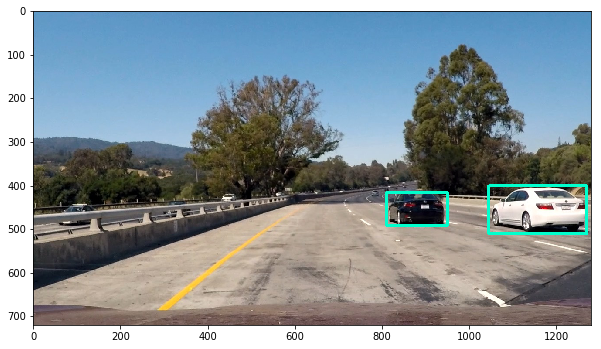

In [38]:
image = mpimg.imread('test_images/test1.jpg')

# Here are the bounding boxes I used
bboxes = [((1045, 400), (1270, 510)), ((810, 416), (950, 491))] 

result = draw_boxes(image, bboxes)
plt.figure(figsize=(10,10))
plt.imshow(result)

Your function returned a count of 8792  cars and 8975  non-cars
of size:  (64, 64, 3)  and data type: float32


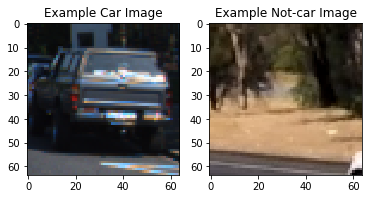

In [3]:
import glob
#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

images = glob.glob('non-vehicles/*/*.png')
cars = []
notcars = []

for image in images:
    notcars.append(image)

images = glob.glob('vehicles/*/*.png')
for image in images:    
    cars.append(image)

data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [4]:
# A function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# A function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



# A function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# A function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        #print (len(spatial_features))
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        #print (len(hist_features))
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        #print (len(hog_features))
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# A function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = []
        file_features = single_img_features(image, color_space, spatial_size,
                        hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)   
        #print (len(file_features[0]), len(file_features[1]), len(file_features[2]))
        features.append(file_features)
        #image = cv2.flip(image,1)
        #file_features = single_img_features(image, color_space, spatial_size,
        #                hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
        #                spatial_feat, hist_feat, hog_feat)   
        #features.append(file_features)
    # Return list of feature vectors
    return features


In [5]:
import numpy as np
import cv2

# A function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        #print (window[0][1],window[1][1], window[0][0],window[1][0])
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #test_features = np.array(features).reshape(1, -1)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

# A function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list



In [6]:
import pickle

#sample_size = 1500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) #(32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
pkl_filename = "pickle_model.pkl"  


In [7]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import train_test_split

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

#Run model

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

with open(pkl_filename, 'wb') as file:  
    pickle.dump(svc, file)
    pickle.dump(X_scaler, file)


C:\Users\abnandi\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2052
5.34 Seconds to train SVC...
Test Accuracy of SVC =  0.9834


In [8]:
with open(pkl_filename, 'rb') as file:  
    svc = pickle.load(file)
    X_scaler = pickle.load(file)

# A single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2LUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (int) ((window // pix_per_cell) - cell_per_block + 1)
    cells_per_step_x = scale  # Instead of overlap, define how many cells to step
    cells_per_step_y = scale  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step_x + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step_y + 1
    #print (nxsteps, nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    on_windows = []
    for xb in range(int(nxsteps)):
        for yb in range(int(nysteps)):
            tf = []
            ypos = (int) (yb*cells_per_step_y)
            xpos = (int) (xb*cells_per_step_x)
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = hog_feat1
            #print(len(hog_features))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            #print(len(spatial_features))
            #print(len(hist_features))
            tf.append(spatial_features)
            tf.append(hist_features)
            tf.append(hog_features)
            # Scale features and make a prediction
            nf = np.concatenate(tf)
            test_features = X_scaler.transform(np.array(nf).reshape(1, -1))    
            #test_features = np.array(nf).reshape(1, -1)
            #test_prediction = svc.predict(test_features)
            decision_val = svc.decision_function(test_features)
            
            #if test_prediction == 1:
            if decision_val > 2:
                #print(svc.decision_function(test_features))
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_windows.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,255,205),6) 

    return on_windows


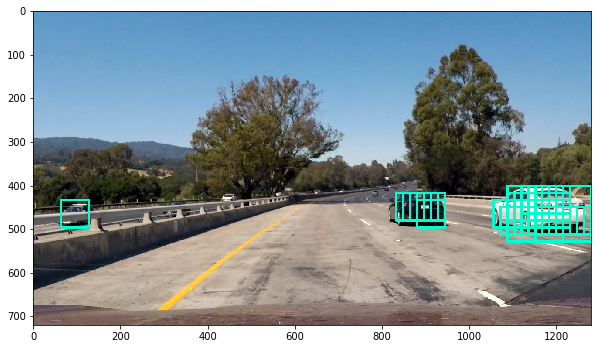

In [9]:
def get_prediction(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    windows = []

    ystart = 400
    ystop = 520
    scale = 1
    windows = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    ystart = 400
    ystop = 600
    scale = 2
    windows += find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    #ystart = 450
    #ystop = 700
    #scale = 3
    #windows += find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    return windows

img = mpimg.imread('test_images/test1.jpg')

windows = get_prediction(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 64)
out_img = draw_boxes(img, windows, color=(0, 255, 205), thick=3)

plt.figure(figsize=(10,10))
plt.imshow(out_img)

2.69 Seconds to process test images


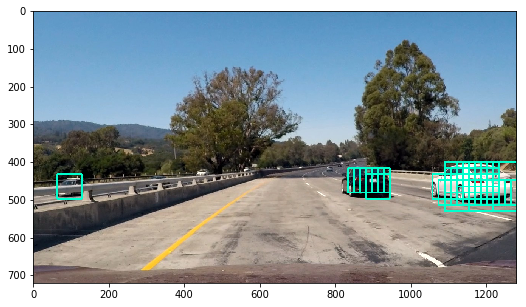

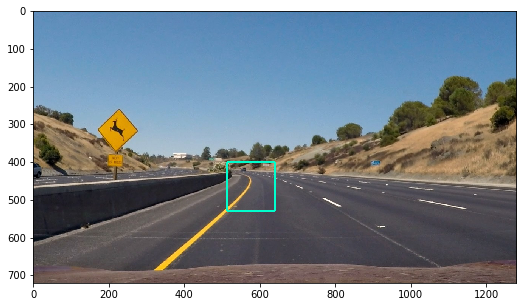

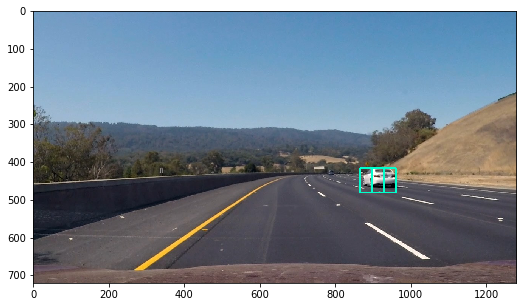

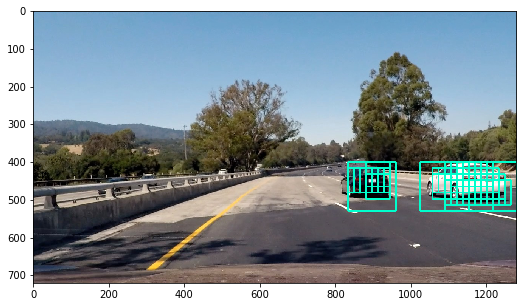

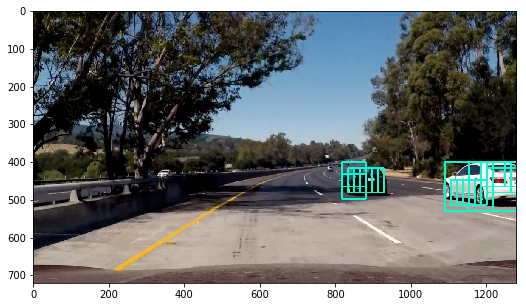

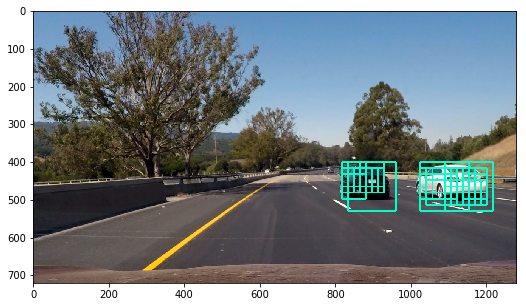

In [10]:
import time

t=time.time() # Start time
for image_p in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(image_p)
    
    hot_windows = get_prediction(image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 64)
    out_img = draw_boxes(image, hot_windows, color=(0, 255, 205), thick=3)
    plt.figure(figsize=(10,5))
    plt.imshow(out_img)
print(round(time.time()-t, 2), 'Seconds to process test images')

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap



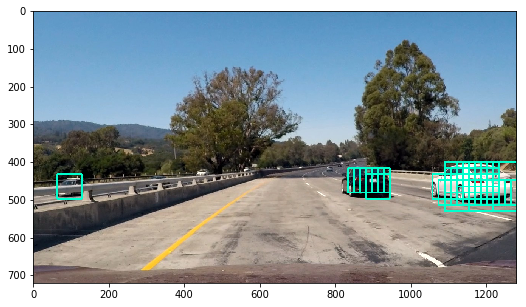

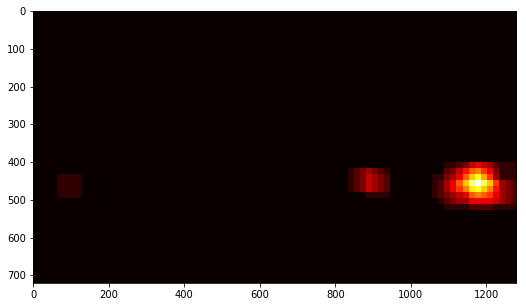

In [12]:
# Test out the heatmap
img = mpimg.imread('test_images/test1.jpg')

windows = get_prediction(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 64)
out_img = draw_boxes(img, windows, color=(0, 255, 205), thick=3)

plt.figure(figsize=(10,5))
plt.imshow(out_img)

heatmap_img = np.zeros_like(img[:,:,0])
heatmap_img = add_heat(heatmap_img, windows)
plt.figure(figsize=(10,5))
plt.imshow(heatmap_img, cmap='hot')


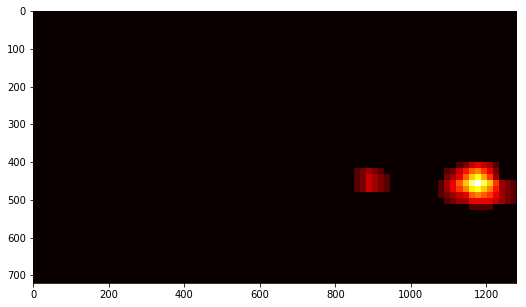

In [13]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,5))
plt.imshow(heatmap_img, cmap='hot')


2 cars found


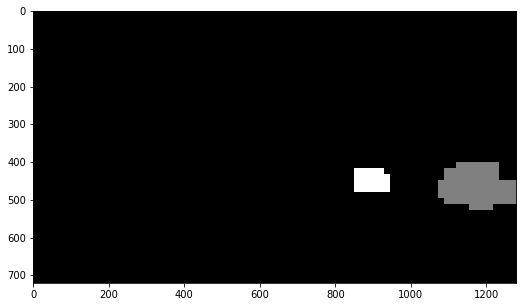

In [14]:
from scipy.ndimage.measurements import label

labels = label(heatmap_img)
plt.figure(figsize=(10,5))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

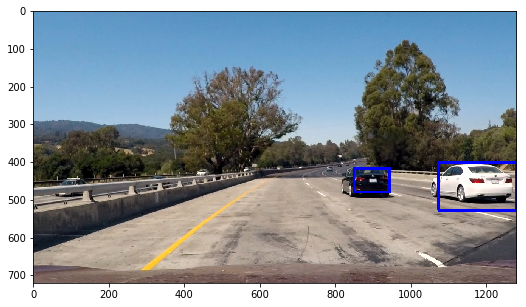

In [15]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.figure(figsize=(10,5))
plt.imshow(draw_img)

In [16]:
def process_frame(img): 
    windows = get_prediction(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 64)
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, windows)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

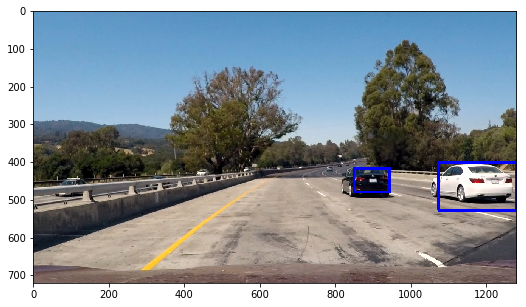

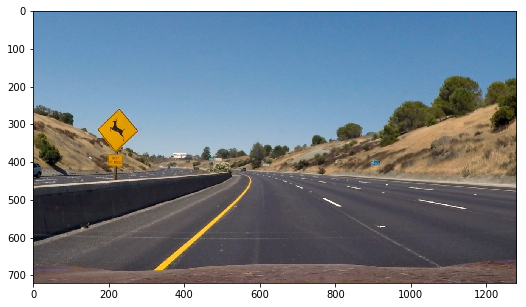

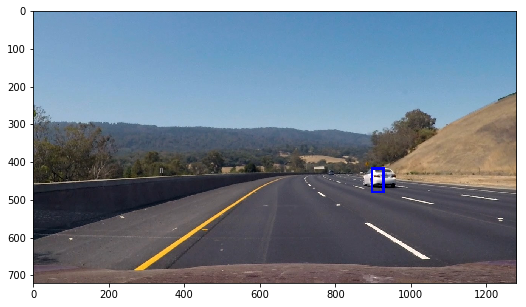

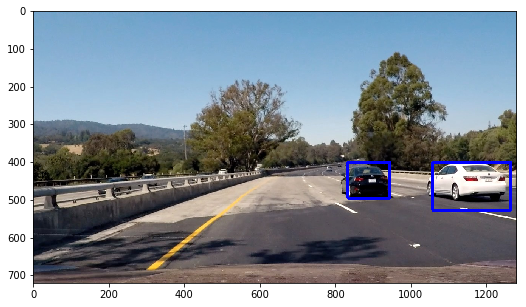

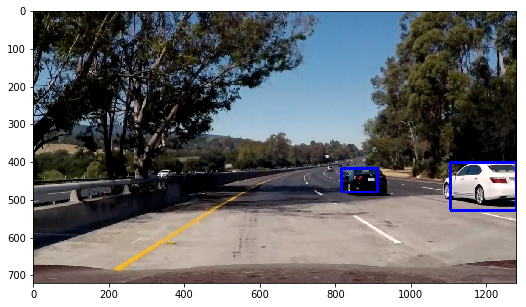

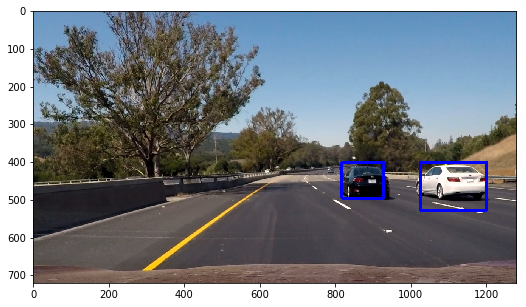

In [25]:
import ntpath

for image_p in glob.glob('test_images/test*.jpg'):
    output_file = './output_images/' + ntpath.basename(image_p)
    image = mpimg.imread(image_p)
    
    out_img = process_frame(image)
    plt.figure(figsize=(10,5))
    plt.imshow(out_img)
    mod_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(output_file, mod_img)

In [18]:
# A class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        self.i = 0
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [19]:
def process_frame_for_boxes(img):
    windows = get_prediction(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 64)
    det.add_rects(windows)
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        if (len(rect_set)) :
            heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects) * 3 // 4)
    #print (len(windows), len(det.prev_rects))
    labels = label(heatmap_img)
    #draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return labels


In [20]:
def process_frame_for_lane(img):
    new_img = np.copy(img)
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    binary_warped, warped, Minv = img_procesing_pipeline_1(new_img)

    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        #l_line.type.append(1)
        select = 1
        l_fit, r_fit, l_lane_inds, r_lane_inds, out_img, all_hist = sliding_window_polyfit(binary_warped, margin, minpix)
    else:
        #l_line.type.append(2)
        select = 2
        l_fit, r_fit, l_lane_inds, r_lane_inds = find_lane_from_prev_fit(binary_warped, l_line.best_fit, r_line.best_fit, margin + 20)
         
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if (l_line.lane_width == -1) :
            l_line.lane_width = x_int_diff
            print (l_line.lane_width)
        elif abs(l_line.lane_width - x_int_diff) > 150:
            #l_line.type.append(3)
            select = (l_line.lane_width - x_int_diff)
            l_fit = None
            r_fit = None
            
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    if l_fit is not None and r_fit is not None:
        left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
        right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
        rad_l, rad_r, d_center = cal_curvature_and_distance_from_center(img, binary_warped, l_fit, r_fit, 
                                                               left_fitx, right_fitx, 0, True)
        if ((rad_l * rad_r) > 0) :
            l_line.add_fit(l_fit, l_lane_inds)
            r_line.add_fit(r_fit, r_lane_inds)
        else :
            select = 4
            
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        #l_line.type.append(4)
        left_fitx = l_line.best_fit[0]*ploty**2 + l_line.best_fit[1]*ploty + l_line.best_fit[2]
        right_fitx = r_line.best_fit[0]*ploty**2 + r_line.best_fit[1]*ploty + r_line.best_fit[2]
        rad_l, rad_r, d_center = cal_curvature_and_distance_from_center(img, binary_warped, l_line.best_fit, r_line.best_fit, 
                                                               left_fitx, right_fitx, 0, False)
        img_out1 = draw_lane(new_img, binary_warped, l_line.best_fit, r_line.best_fit, Minv)
        img_out = write_data(img_out1, (rad_l+rad_r)/2, d_center, select)
    else:
        #l_line.type.append(3)
        select = 5
        img_out = new_img
        img_out = write_data(img_out, 0, 0, select)
    
    return img_out



In [21]:
def process_image_merged(img):
    img_with_lane = process_frame_for_lane(np.copy(img))
    labels = process_frame_for_boxes(img)
    draw_img, rects = draw_labeled_bboxes(img_with_lane, labels)
    return draw_img

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

l_line = Line()
r_line = Line()
det = Vehicle_Detect()

test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_image_merged)
%time clip_test_out.write_videofile(test_out_file, audio=False)

637.273405485
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [12:18<00:00,  1.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 12min 20s
